# Functional connectivity results
This is just a wrapper to load the already generated NBS results (see taskfc_PPI_results.py)

In [1]:
import sys
import numpy as np
sys.path.append("../code/")
subj_list = list(np.loadtxt('../code/subject_list_exclusions.txt', dtype='str'))

Parameters to consider:
- Number of permutations (10,000)
- Are the rois eroded? (True or False)
- What timeseries extraction method was used? ('region')

In [2]:
import pandas as pd

perms = 10000
eroded = False
ts_method = 'region'
result_dir = '../results/'

if eroded:
    nbs_df = pd.read_csv(result_dir+'nbs_results_perms-'+str(perms)+'_method-'+ts_method+'_eroded.csv')
else:
    nbs_df = pd.read_csv(result_dir+'nbs_results_perms-'+str(perms)+'_method-'+ts_method+'.csv')

display(nbs_df[(nbs_df.test == '1samp') & (nbs_df.contrast == 'threat')])
display(nbs_df[(nbs_df.test == '1samp') & (nbs_df.contrast == 'safety')])

,thresh,perms,contrast,test,comp_n,comp_size,pval
0,1.0,10000.0,threat,1samp,1.0,30.0,0.0227
2,2.5,10000.0,threat,1samp,1.0,1.0,0.4546
3,2.5,10000.0,threat,1samp,2.0,9.0,0.0016
6,3.0,10000.0,threat,1samp,1.0,1.0,0.1500
7,3.0,10000.0,threat,1samp,2.0,5.0,0.0012
10,3.5,10000.0,threat,1samp,1.0,1.0,0.0366
11,3.5,10000.0,threat,1samp,2.0,2.0,0.0043


,thresh,perms,contrast,test,comp_n,comp_size,pval
1,1.0,10000.0,safety,1samp,1.0,27.0,0.0477
4,2.5,10000.0,safety,1samp,1.0,1.0,0.4728
5,2.5,10000.0,safety,1samp,2.0,7.0,0.0024
8,3.0,10000.0,safety,1samp,1.0,1.0,0.1558
9,3.0,10000.0,safety,1samp,2.0,3.0,0.0038
12,3.5,10000.0,safety,1samp,1.0,1.0,0.0345
13,3.5,10000.0,safety,1samp,2.0,1.0,0.0345


In [3]:
display(nbs_df[(nbs_df.test == '2samp') & (nbs_df.contrast == 'threat')])
display(nbs_df[(nbs_df.test == '2samp') & (nbs_df.contrast == 'safety')])

,thresh,perms,contrast,test,comp_n,comp_size,pval
14,1.0,10000.0,threat,2samp,1.0,14.0,0.7785


,thresh,perms,contrast,test,comp_n,comp_size,pval
15,1.0,10000.0,safety,2samp,1.0,13.0,0.8592


In [4]:
display(nbs_df[(nbs_df.test == '2samp') & (nbs_df.contrast == 'rest')])

,thresh,perms,contrast,test,comp_n,comp_size,pval
16,1.0,10000.0,rest,2samp,1.0,28.0,0.1146


## Visualize results

### Set the plot up

In [5]:
# load the matrices
if eroded:
    con_mats_sym = np.load(result_dir+'con_mats_sym_eroded.npy')
else:
    con_mats_sym = np.load(result_dir+'con_mats_sym.npy')

In [6]:
# %% Visualize results
import matplotlib.pyplot as plt
from scipy.stats import ttest_rel, ttest_1samp, ttest_ind
from functions.data_helpers import get_phenotype

n_roi = con_mats_sym.shape[0]
n_subj = con_mats_sym.shape[3]

# these functions help reorganise the matrices
# into a nicer looking plot

# roi labels in line with reformat
roi_labels = ['vmPFC',
              'PCC',
              'dACC',
              'Insula (L)',
              'Insula (R)',
              'Putamen (L)',
              'Putamen (R)',
              'Caudate (L)',
              'Caudate (R)',
              'GP (L)',
              'GP (R)']


def reformat_matrix(X):
    # swap 4 0 (vmpfc and Insula L)
    X = swap_matrix_row(X.copy(), 4, 0)
    # swap 3 1 (pcc and Insula R)
    X = swap_matrix_row(X.copy(), 3, 1)
    # swap 3 4 (Insula R and Insula L)
    X = swap_matrix_row(X.copy(), 3, 4)
    return X


def swap_matrix_row(X, a, b):
    X[[a, b], :] = X[[b, a], :]
    X[:, [a, b]] = X[:, [b, a]]
    return X


# mask upper triangle
t_mat = np.zeros((n_roi, n_roi, 3))
mask = np.triu(np.ones(n_roi), k=0) == 1
plot_thresh = 3

# organise fc mats for plotting
'''
Recall the indices from run_nbs.py
0 = CS+REV - CS-HAB
1 = CS-CON - CS-HAB
2 = CS-REV - CS+HAB
3 = CS+CON - CS+HAB
4 = Resting state

'''
# first, convert beta values to t-stats for vis.
# threat 1 samp
a = con_mats_sym[:, :, 0, :].copy()
b = con_mats_sym[:, :, 1, :].copy()
t, p = ttest_rel(a.reshape(-1, n_subj).T, b.reshape(-1, n_subj).T)
tmp = t.reshape(n_roi, n_roi)
t_mat[:, :, 0] = reformat_matrix(tmp)

# safe 1 samp
a = con_mats_sym[:, :, 2, :].copy()
b = con_mats_sym[:, :, 3, :].copy()
t, p = ttest_rel(a.reshape(-1, n_subj).T, b.reshape(-1, n_subj).T)
tmp = t.reshape(11, 11)
t_mat[:, :, 1] = reformat_matrix(tmp)

# rest 1 samp
a = con_mats_sym[:, :, 4, :].copy()
t, p = ttest_1samp(a.reshape(-1, n_subj).T, popmean=0)
tmp = t.reshape(11, 11)
t_mat[:, :, 2] = reformat_matrix(tmp)

# 2 sample stats
group_idx = get_phenotype(subj_list, ['participants'])['group']
tmp = con_mats_sym[:, :, 0, :] - con_mats_sym[:, :, 1, :]
a = tmp[:, :, group_idx == 'control']
b = tmp[:, :, group_idx == 'patient']
t, p = ttest_ind(a.reshape(-1, a.shape[2]).T, b.reshape(-1, b.shape[2]).T)
tmp = t.reshape(11, 11)
tmp = reformat_matrix(tmp)
t_mat[mask, 0] = tmp[mask]

group_idx = get_phenotype(subj_list, ['participants'])['group']
tmp = con_mats_sym[:, :, 2, :] - con_mats_sym[:, :, 3, :]
a = tmp[:, :, group_idx == 'control']
b = tmp[:, :, group_idx == 'patient']
t, p = ttest_ind(a.reshape(-1, a.shape[2]).T, b.reshape(-1, b.shape[2]).T)
tmp = t.reshape(11, 11)
tmp = reformat_matrix(tmp)
t_mat[mask, 1] = tmp[mask]

group_idx = get_phenotype(subj_list, ['participants'])['group']
tmp = con_mats_sym[:, :, 4, :].copy()
a = tmp[:, :, group_idx == 'control']
b = tmp[:, :, group_idx == 'patient']
t, p = ttest_ind(a.reshape(-1, a.shape[2]).T, b.reshape(-1, b.shape[2]).T)
tmp = t.reshape(11, 11)
tmp = reformat_matrix(tmp)
t_mat[mask, 2] = tmp[mask]

# get masks that represent sig effects
# given no group effects, mask out the top triangle
mask = np.triu(np.ones(n_roi), k=0) == 1
sig_mat = np.zeros((n_roi, n_roi, 3))
for i, con in enumerate(['threat', 'safety']):
    print(con)
    in_file = ('nbs_mats/nbs_thresh-'+str(plot_thresh)
               + '_perms-'+str(perms)
               + '_contrast-'+con
               + '_test-1samp'
               + '_comp_n-'+str(1)
               + '_method-'+ts_method
               + '.csv'
               )
    adj = np.loadtxt(result_dir+in_file, delimiter=',')
    tmp = t.reshape(11, 11)
    adj = reformat_matrix(adj)
    adj[mask] = 0
    sig_mat[:, :, i] = adj.copy()

    # print the results
    for i in range(adj.shape[0]):
        for j in range(adj.shape[1]):
            if adj[i, j] == 1:
                print(roi_labels[i], '<--->', roi_labels[j])

threat
Insula (R) <---> Insula (L)
Putamen (R) <---> Putamen (L)
Caudate (R) <---> Insula (L)
Caudate (R) <---> Insula (R)
Caudate (R) <---> Putamen (R)
safety
Insula (R) <---> Insula (L)
Putamen (L) <---> Insula (L)
Putamen (R) <---> Putamen (L)


### Perform heatmap plot

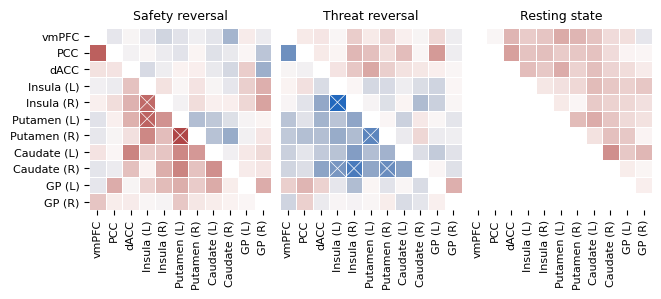

In [7]:
import seaborn as sns
fig, axs = plt.subplot_mosaic("""
                              ABC
                              """, figsize=(6.5, 5), constrained_layout=True)
plt.rc('axes', labelsize=5)
plt.rcParams['svg.fonttype'] = 'none'
ax_list = ['A', 'B', 'C']

# work out what the vmax and vmin should be across plots
vmax = 4.5
vmin = vmax*-1

#cmap = sns.diverging_palette(230, 20, as_cmap=True)
cmap = 'vlag'

# start plotting
for i, ax in enumerate(['B', 'A', 'C']):
    if i != 1:
        y_labels = [''] * len(roi_labels)
    else:
        y_labels = roi_labels.copy()

    if i == 2:
        mask = np.tril(m=np.ones(n_roi), k=0)
    else:
        mask = np.eye(n_roi)
    # Draw the heatmap with the mask and correct aspect ratio
    g = sns.heatmap(t_mat[:, :, i], mask=mask, cmap=cmap, center=0,
                    yticklabels=y_labels, xticklabels=roi_labels,
                    vmin=vmin, vmax=vmax,
                    ax=axs[ax], square=True, linewidths=0.5, cbar=False)

    # draw significance markers
    for j in range(sig_mat.shape[0]):
        for jj in range(sig_mat.shape[1]):
            if sig_mat[j, jj, i]:
                axs[ax].plot([jj,jj+1], [j,j+1], color='w', linewidth=0.5)
                axs[ax].plot([jj,jj+1], [j+1,j], color='w', linewidth=0.5)

# format
for ax in ax_list:
    axs[ax].tick_params(axis="x", labelsize=8)
    axs[ax].tick_params(axis="y", labelsize=8)
axs['B'].tick_params(left=False)
axs['C'].tick_params(left=False)

axs['A'].set_title('Safety reversal', fontsize=9)
axs['B'].set_title('Threat reversal', fontsize=9)
axs['C'].set_title('Resting state', fontsize=9)

plt.savefig('../figures/conn_mats.svg')
plt.show()

## Condition-wise plot

In [8]:
# load the matrices
if eroded:
    con_mats_sym = np.load(result_dir+'con_mats_sym_eroded.npy')
else:
    con_mats_sym = np.load(result_dir+'con_mats_sym.npy')
'''
Recall the indices from run_nbs.py
0 = CS+REV - CS-HAB
1 = CS-CON - CS-HAB
2 = CS-REV - CS+HAB
3 = CS+CON - CS+HAB
4 = Resting state

'''
trial_list = ['CS+', 'CS-', 'CS+', 'CS-']
phase_list = ['Conditioning', 'Conditioning', 'Reversal', 'Reversal']

# threat significant effects
results = pd.DataFrame()
for i, contrast in enumerate(['Threat', 'Safety']):
    for c_idx, cond in enumerate([3, 1, 0, 2]):

        data = np.zeros((len(subj_list)))
        for s in range(90):
            tmp = con_mats_sym[:, :, cond, s].copy()
            tmp = reformat_matrix(tmp.copy())
            data[s] = np.mean(tmp[sig_mat[: , :, i]==1], axis=0)

        df = pd.DataFrame()
        df['subj'] = subj_list
        df['contrast'] = [contrast] * len(subj_list)
        df['trial_type'] = trial_list[c_idx]
        df['connectivity'] = data.copy()
        df['phase'] = phase_list[c_idx]
        df['group'] = get_phenotype(subj_list, label_list=['participants']).group.values
        results = pd.concat([results, df])
results.head()

,subj,contrast,trial_type,connectivity,phase,group
0,sub-control01,Threat,CS+,-0.117868,Conditioning,control
1,sub-control03,Threat,CS+,-1.024553,Conditioning,control
2,sub-control04,Threat,CS+,1.789471,Conditioning,control
3,sub-control05,Threat,CS+,-1.564465,Conditioning,control
4,sub-control06,Threat,CS+,0.042601,Conditioning,control


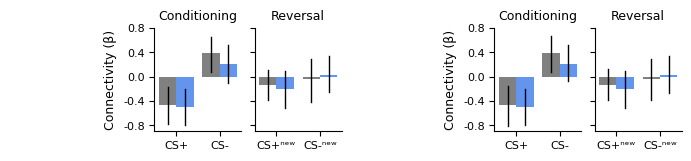

In [9]:
# create plot
fig, axs = plt.subplot_mosaic("""
                            ZABXCD
                            """, figsize=(6.8, 1.5), constrained_layout=True)
ax_list = ['A', 'B', 'C', 'D']
plt.rc('axes', labelsize=9)
plt.rcParams['svg.fonttype'] = 'none'

c = 0
for con in ['Safety', 'Threat']:
    for phase in ['Conditioning', 'Reversal']:
        # get phase and contrast specific data
        tmp_df = results.loc[(results.phase == phase)
                                & (results.contrast == contrast)]

        # simple bar plot
        g = sns.barplot(data=tmp_df, x='trial_type', y='connectivity', hue='group', units='subj',
                        palette=['grey', 'cornflowerblue'], ax=axs[ax_list[c]], order=['CS+', 'CS-'],
                        saturation=1, errcolor='k', errwidth=1)

        g.set(ylim=(-0.9, 0.8))  # all ratings should be visible
        g.set(xlabel='')

        # change the fontsize
        g.set_yticks(np.arange(-.8, 1.2, .4))
        g.set_yticklabels(np.arange(-.8, 1.2, .4).round(1), fontsize=8)
        g.set_xticks(range(0, 2))
        g.set_xticklabels(['CS+', 'CS-'], fontsize=8)

        # y axis details
        if c == 0 or c == 2:
            g.set_ylabel('Connectivity (β)', size=9)
        else:
            g.set(ylabel='')  # remove y info
            g.set(yticklabels=[])

        # x axis details
        g.set_title(phase.title(), fontdict={'fontsize': 9})

        if c == 1 or c == 3:
            g.set_xticklabels(['CS+ⁿᵉʷ', 'CS-ⁿᵉʷ'], fontsize=8)

        g.get_legend().remove()
        c = c+1

sns.despine()
axs['Z'].set_axis_off()
axs['X'].set_axis_off()
plt.savefig('../figures/connectivity_barplots.svg', dpi=300, pad_inches=0.2)
plt.show()

In [19]:
# plot some brains too.
from nilearn import plotting
roi_dir = '/home/lukeh/hpcworking/lukeH/projects/OCDbaseline/data/derivatives/masks/'
cort_coords = pd.read_csv(roi_dir+'Savage_coords.csv')
sc_coords = pd.read_csv(roi_dir+'tian_coords.csv')
sc_coords = sc_coords.drop([0, 1, 2, 3, 7, 8, 9, 10, 14, 15, 16, 17, 18 , 19 , 20 , 21, 22, 23, 24 ,25, 26, 27])
roi_coords = pd.concat([cort_coords, sc_coords])
roi_df = pd.read_csv('../code/roi_details.csv')

# reorder to same as matrices
reorder_label = ['vmpfc', 'pcc', 'acc', 'leftInsula', 'rightInsula',
                 'leftPUT', 'rightPUT', 'leftCAU', 'rightCAU', 'leftGP', 'rightGP']
roi_coords = roi_coords.reset_index(drop=True)
roi_coords = roi_coords.reindex([3, 4, 1, 2, 0, 9, 6, 10, 7, 8, 5])
coords = roi_coords[['x', 'y', 'z']].copy()

# save out for surfice
coords['var1'] = 1
coords['var2'] = 1
coords['label'] = roi_coords['label']
coords.to_csv('../figures/nodes.NODE', sep='\t', header=False, index=False)

# edges for threat
out = sig_mat[:, :, 0]+sig_mat[:, :, 0].T
tmp = pd.DataFrame(data=out)
tmp.to_csv('../figures/threat_edge.EDGE', sep='\t', header=False, index=False)

# edges for safet
out = sig_mat[:, :, 1]+sig_mat[:, :, 1].T
tmp = pd.DataFrame(data=out)
tmp.to_csv('../figures/safety_edge.EDGE', sep='\t', header=False, index=False)

/home/lukeh/miniconda3/envs/py39/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedCheckFailedWarning: Failed to check for latest version of package.
Set the environment variable OUTDATED_RAISE_EXCEPTION=1 for a full traceback.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [44]:
from shutil import copyfile

for c in [0, 1]:
    idx = np.where(np.sum(sig_mat[:,:,c]+sig_mat[:,:,c].T, axis=1))[0]
    for i in idx:
        row = roi_coords.iloc[i]
        roi_label = row.spm +'_'+ row.label+'.nii.gz'
        print(roi_label)
        suc = copyfile(roi_dir+roi_label, '../figures/'+roi_label)



Savage_threat_leftInsula.nii.gz
Savage_threat_rightInsula.nii.gz
tian_threat_leftPUT.nii.gz
tian_threat_rightPUT.nii.gz
tian_threat_rightCAU.nii.gz
Savage_threat_leftInsula.nii.gz
Savage_threat_rightInsula.nii.gz
tian_threat_leftPUT.nii.gz
tian_threat_rightPUT.nii.gz


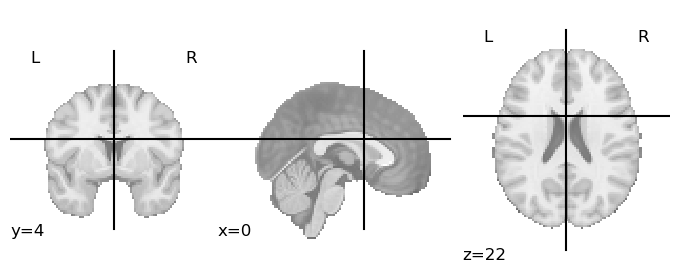

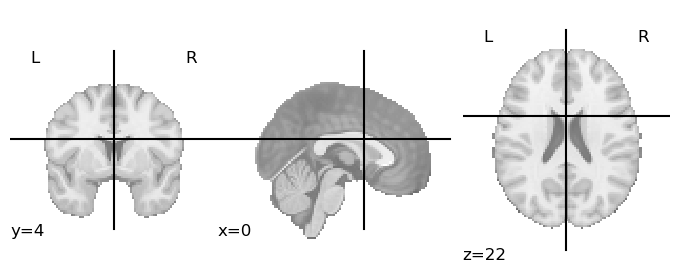

In [46]:
plotting.plot_anat()
plt.show()

# Effect of Awareness

In [ ]:
if eroded:
    nbs_df = pd.read_csv(result_dir+'nbs_results_awareness_perms-'+str(perms)+'_method-'+ts_method+'_eroded.csv')
else:
    nbs_df = pd.read_csv(result_dir+'nbs_results_awareness_perms-'+str(perms)+'_method-'+ts_method+'.csv')

display(nbs_df[(nbs_df.test == '2samp-Control-Unaware') & (nbs_df.contrast == 'threat')])
display(nbs_df[(nbs_df.test == '2samp-Control-Unaware') & (nbs_df.contrast == 'safety')])

display(nbs_df[(nbs_df.test == '2samp-Patient-Unaware') & (nbs_df.contrast == 'threat')])
display(nbs_df[(nbs_df.test == '2samp-Patient-Unaware') & (nbs_df.contrast == 'safety')])

,thresh,perms,contrast,test,comp_n,comp_size,pval
0,1.0,10000.0,threat,2samp-Control-Unaware,1.0,18.0,0.4838
6,2.5,10000.0,threat,2samp-Control-Unaware,1.0,1.0,0.4840


,thresh,perms,contrast,test,comp_n,comp_size,pval
1,1.0,10000.0,safety,2samp-Control-Unaware,1.0,21.0,0.2547


,thresh,perms,contrast,test,comp_n,comp_size,pval
3,1.0,10000.0,threat,2samp-Patient-Unaware,1.0,18.0,0.4772
9,2.5,10000.0,threat,2samp-Patient-Unaware,1.0,1.0,0.5002


,thresh,perms,contrast,test,comp_n,comp_size,pval
4,1.0,10000.0,safety,2samp-Patient-Unaware,1.0,21.0,0.2614
10,2.5,10000.0,safety,2samp-Patient-Unaware,1.0,4.0,0.0239


In [ ]:
display(nbs_df[(nbs_df.contrast == 'rest')])

,thresh,perms,contrast,test,comp_n,comp_size,pval
2,1.0,10000.0,rest,2samp-Control-Unaware,1.0,20.0,0.3179
5,1.0,10000.0,rest,2samp-Patient-Unaware,1.0,17.0,0.6118
7,2.5,10000.0,rest,2samp-Control-Unaware,1.0,1.0,0.5290
8,2.5,10000.0,rest,2samp-Control-Unaware,2.0,1.0,0.5290
11,2.5,10000.0,rest,2samp-Patient-Unaware,1.0,2.0,0.1406
12,3.0,10000.0,rest,2samp-Control-Unaware,1.0,1.0,0.1840
13,3.0,10000.0,rest,2samp-Patient-Unaware,1.0,1.0,0.2011
